A célula abaixo corrige um problma com a biblioteca nltk que estávamos tendo.

In [ ]:
import nltk
from nltk.tokenize import word_tokenize

nltk.data.path.append('./.venv/nltk_data')  

nltk.download('punkt', download_dir='./.venv/nltk_data')
nltk.download('stopwords', download_dir='./.venv/nltk_data')
nltk.download('punkt_tab', download_dir='./.venv/nltk_data')


[nltk_data] Downloading package punkt to ./.venv/nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.
[nltk_data] Downloading package stopwords to ./.venv/nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.
[nltk_data] Downloading package punkt_tab to ./.venv/nltk_data...
[nltk_data]   Unzipping tokenizers\punkt_tab.zip.


True

## Limpeza dos textos
Abaixo definimos as funções usadas para limpeza do texto

In [23]:
import re
import unicodedata
from nltk.tokenize import sent_tokenize

def limpeza_texto(texto):

    # 1. Corrigir quebras de linha excessivas
    texto = texto.replace('\n', '')
    
    # 2. Corrigir múltiplos espaços
    texto = re.sub(r'[ \t]+', ' ', texto)
    
    # 3. Remover pontuação desnecessária (mas manter . , ? — e aspas)
    texto = re.sub(r'[!;:()*[\]{}<>]', '', texto)
    
    # 4. Converter para minúsculas
    texto = texto.lower()
    
    # 5. Remover acentos
    texto = unicodedata.normalize('NFKD', texto)
    texto = ''.join(c for c in texto if not unicodedata.combining(c))
    
    return texto

def limpar_e_tokenizar_texto(texto):
    # Limpa o texto primeiro
    texto_limpo = limpeza_texto(texto)
    
    sentences = sent_tokenize(texto_limpo, language='portuguese')
    # Remove sentenças vazias
    sentences = [s for s in sentences if s.strip()]
    # Tokeniza as sentenças e achata a lista de listas
    tokens = [token for s in sentences for token in word_tokenize(s, language='portuguese')]

    return tokens

def extrair_titulo_autor(nome_arquivo):
    # Remove "preprocessado_" e ".txt" ou ".json"
    nome_limpo = re.sub(r'^preprocessado_', '', nome_arquivo)
    nome_limpo = re.sub(r'\.(txt|json)$', '', nome_limpo)
    
    # Separar título e autor
    match = re.match(r'(.+?) \((.+?)\)', nome_limpo)
    if match:
        titulo, autor = match.groups()
        return titulo.strip(), autor.strip()
    else:
        return nome_limpo.strip(), None  # Se não bater, só retorna o título

### Tokenização e Armazenamento
Na célula abaixo realizamos a tokenização e armazenamento dos textos em um json com título do texto, nome do autor, e conteúdo tokenizado.

In [ ]:
import os
import json

# Caminhos
caminho_txts = "data/txts"
caminho_saida_pasta = "data/textos_processados"
os.makedirs(caminho_saida_pasta, exist_ok=True)

for arquivo_nome in os.listdir(caminho_txts):
    dumped_dict = {}
    dumped_dict['titulo'] = arquivo_nome.split('(')[0].strip()
    dumped_dict['autor'] = arquivo_nome.split('(')[1].replace(')', '').replace('.txt','').strip()
    dumped_dict['tokens'] = []
    caminho_arquivo = os.path.join(caminho_txts, arquivo_nome)
    if os.path.isfile(caminho_arquivo):
        with open(caminho_arquivo, 'r', encoding='utf-8') as arquivo:
            texto_pre = arquivo.read()
            
            # Dividir em parágrafos
            frases = texto_pre.split('.')
            
            for frase in frases:
                frase = frase.strip()
                if frase:
                    tokens = limpar_e_tokenizar_texto(frase)
                    dumped_dict['tokens'].append(tokens)
            
            caminho_saida = os.path.join(caminho_saida_pasta, "preprocessado_" + arquivo_nome.replace('.txt', '.json'))
            with open(caminho_saida, 'w', encoding='utf-8') as arquivo_saida:
                json.dump(dumped_dict, arquivo_saida, ensure_ascii=False, indent=2)
            
            print(f"\nTokens estruturados salvos em: {caminho_saida}")




Tokens estruturados salvos em: data/textos_processados\preprocessado_A Cartomante (Machado de Assis).json

Tokens estruturados salvos em: data/textos_processados\preprocessado_Dom Casmurro (Machado de Assis).json

Tokens estruturados salvos em: data/textos_processados\preprocessado_O Cortiço (Aluisio de Azevedo).json

Tokens estruturados salvos em: data/textos_processados\preprocessado_O Mulato (Aluisio Azevedo).json


# A partir daqui parece teu, Baiano

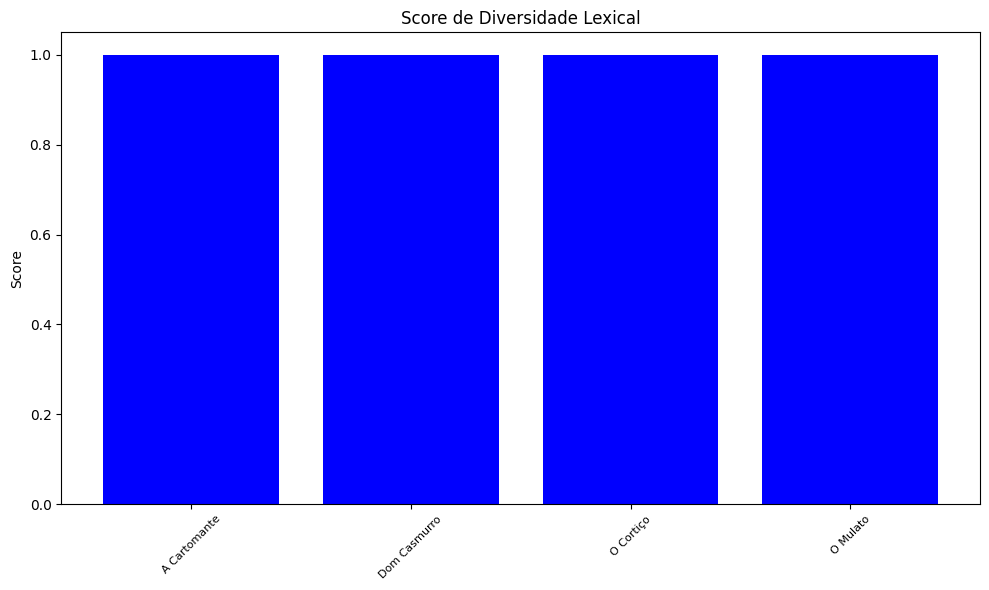

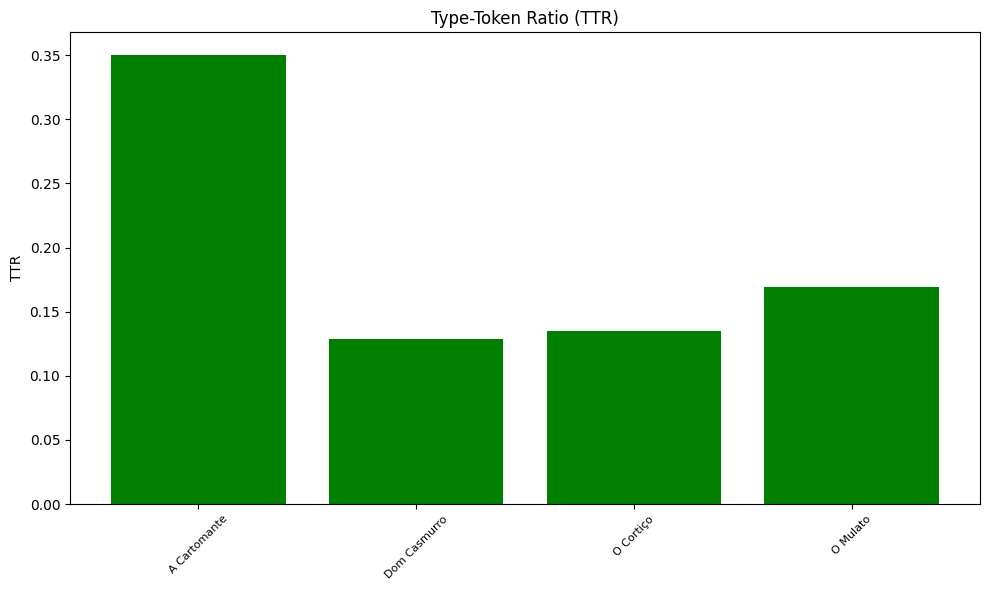

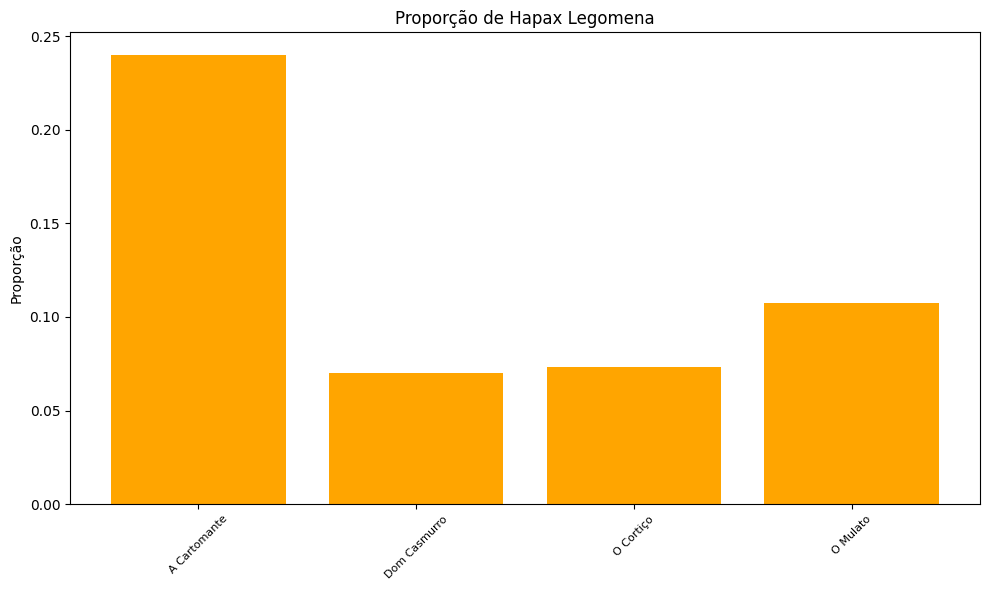

In [ ]:
import os
import json
from collections import Counter
import matplotlib.pyplot as plt

# Caminho para os textos processados
caminho_textos_processados = "data/textos_processados"

def normalizar(valor, minimo, maximo, escala_min=1, escala_max=5):
    valor_normalizado = (valor - minimo) / (maximo - minimo)
    valor_normalizado = max(0, min(1, valor_normalizado)) 
    return escala_min + valor_normalizado * (escala_max - escala_min)

def diversidade_lexical(tokens):
    """
    Calcula a diversidade lexical do texto com normalização.
    
    Args:
        tokens (list): Lista de tokens do texto
        
    Returns:
        dict: Análise de diversidade lexical
    """
    # Filtrar apenas tokens alfabéticos
    tokens_alfabeticos = [t.lower() for t in tokens if re.match(r'[a-zA-ZáàâãéèêíìóòôõúùûçÁÀÂÃÉÈÊÍÌÓÒÔÕÚÙÛÇ]+$', t)]

    # Contar tokens e types
    num_tokens = len(tokens_alfabeticos)
    num_types = len(set(tokens_alfabeticos))

    if num_tokens == 0:
        return {
            'ttr': 0,
            'hapax_legomena': 0,
            'score_diversidade': 1 
        }

    # Calcular Type-Token Ratio (TTR)
    ttr = num_types / num_tokens

    # Calcular Hapax Legomena (palavras que aparecem só uma vez)
    contador = Counter(tokens_alfabeticos)
    hapax_legomena = sum(1 for palavra, freq in contador.items() if freq == 1)
    proporcao_hapax = hapax_legomena / num_tokens

    # Normalizar TTR (esperado de 0.4 a 0.8 normalmente)
    score_ttr = normalizar(ttr, minimo=0.4, maximo=0.8)

    # Normalizar Hapax (esperado de 0.3 a 0.7)
    score_hapax = normalizar(proporcao_hapax, minimo=0.3, maximo=0.7)

    # Score final (média dos dois)
    score_diversidade = (score_ttr + score_hapax) / 2

    return {
        'ttr': ttr,
        'score_ttr': score_ttr,
        'num_types': num_types,
        'num_tokens': num_tokens,
        'hapax_legomena': hapax_legomena,
        'proporcao_hapax': proporcao_hapax,
        'score_diversidade': score_diversidade,
        'score_palavras_unicas': score_hapax
    }

# Iterar sobre os textos processados e calcular a diversidade lexical
resultados_por_texto = []
for arquivo_nome in os.listdir(caminho_textos_processados):
    caminho_arquivo = os.path.join(caminho_textos_processados, arquivo_nome)
    if os.path.isfile(caminho_arquivo) and arquivo_nome.endswith('.json'):
        with open(caminho_arquivo, 'r', encoding='utf-8') as arquivo:
            dados = json.load(arquivo)
            tokens = [token for sublist in dados['tokens'] for token in sublist]
            resultado = diversidade_lexical(tokens)
            resultado['titulo'] = dados.get('titulo', 'Desconhecido')
            resultados_por_texto.append(resultado)

# Plotar os resultados
titulos = [r['titulo'] for r in resultados_por_texto]
scores_diversidade = [r['score_diversidade'] for r in resultados_por_texto]
ttrs = [r['ttr'] for r in resultados_por_texto]
proporcoes_hapax = [r['proporcao_hapax'] for r in resultados_por_texto]

# Gráfico 1: Score de Diversidade
plt.figure(figsize=(10, 6))
plt.bar(titulos, scores_diversidade, color='blue')
plt.title('Score de Diversidade Lexical')
plt.ylabel('Score')
plt.xticks(rotation=45, fontsize=8)
plt.tight_layout()
plt.show()

# Gráfico 2: TTR
plt.figure(figsize=(10, 6))
plt.bar(titulos, ttrs, color='green')
plt.title('Type-Token Ratio (TTR)')
plt.ylabel('TTR')
plt.xticks(rotation=45, fontsize=8)
plt.tight_layout()
plt.show()

# Gráfico 3: Proporção de Hapax Legomena
plt.figure(figsize=(10, 6))
plt.bar(titulos, proporcoes_hapax, color='orange')
plt.title('Proporção de Hapax Legomena')
plt.ylabel('Proporção')
plt.xticks(rotation=45, fontsize=8)
plt.tight_layout()
plt.show()



No sentence-transformers model found with name neuralmind/bert-large-portuguese-cased. Creating a new one with mean pooling.


Resultados para preprocessado_A Cartomante (Machado de Assis).json:
{'coesao_score': 2.22, 'conectivos_encontrados': ['e', 'mas', 'entretanto', 'assim', 'logo', 'pois', 'porque', 'quando', 'enquanto', 'se', 'caso', 'nem', 'ou', 'ora', 'quer', 'como', 'quanto', 'para que', 'porque', 'realmente', 'principalmente', 'tanto', 'quanto'], 'num_conectivos': 23, 'proporcao_conectivos': 0.007, 'similaridade_media': 0.823, 'num_sentencas': 206}


Resultados para preprocessado_Dom Casmurro (Machado de Assis).json:
{'coesao_score': 2.1, 'conectivos_encontrados': ['e', 'mas', 'contudo', 'entretanto', 'portanto', 'assim', 'logo', 'pois', 'porque', 'uma vez que', 'quando', 'enquanto', 'se', 'caso', 'embora', 'apesar de', 'todavia', 'ainda que', 'conquanto', 'nem', 'ou', 'ora', 'quer', 'seja', 'assim como', 'como', 'tal como', 'quanto', 'do mesmo modo', 'igualmente', 'em vez de', 'ao passo que', 'desde que', 'a fim de que', 'para que', 'antes que', 'logo que', 'assim que', 'depois que', 'porque', 'porq

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

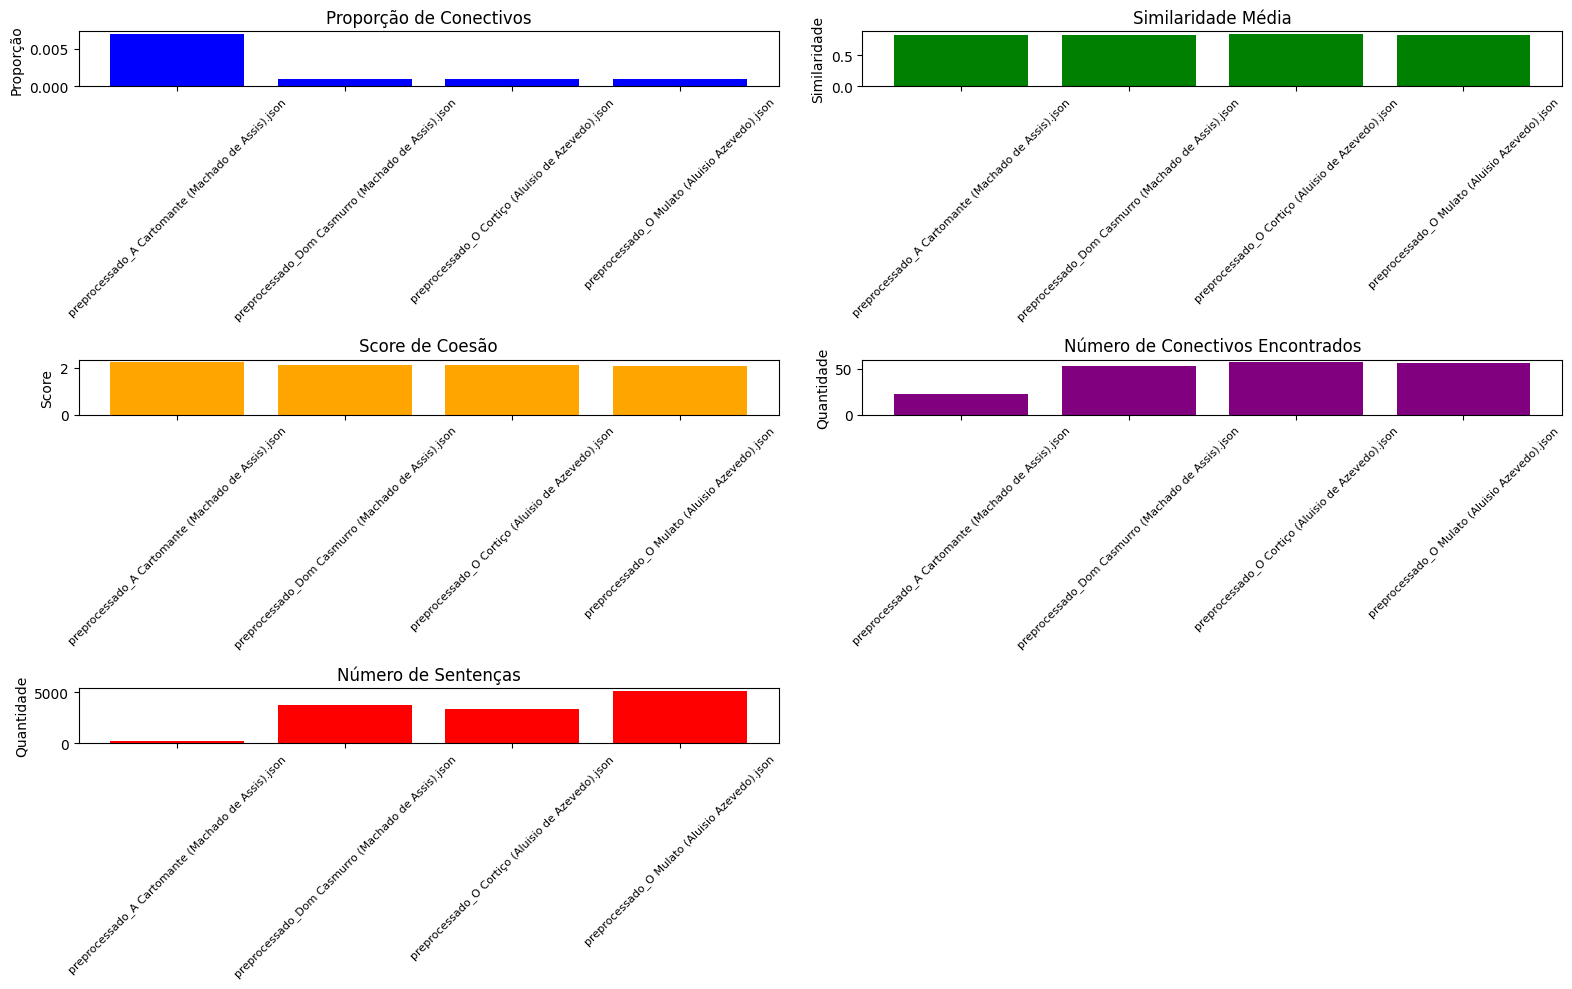

In [13]:
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer
import numpy as np

# Modelo de embeddings
model = SentenceTransformer('neuralmind/bert-large-portuguese-cased')

def get_sentence_embeddings(sentences, model):
    """
    Obtém o embedding médio para cada sentença usando um modelo pré-treinado.

    Args:
        sentences (list): Lista de sentenças.
        model: Modelo de embedding.

    Returns:
        dict: Mapeamento de sentença para vetor de embedding.
    """
    embeddings = {}
    for i, sentence in enumerate(sentences):
        if not isinstance(sentence, str) or len(sentence) < 5:
            continue
        sentence_embedding = model.encode(sentence, show_progress_bar=False)
        embeddings[sentence] = sentence_embedding
    return embeddings

def analisar_coesao_sentences(sentences, words, embeddings):
    """
    Analisa a coesão e coerência do texto de forma detalhada.

    Args:
        sentences (list): Lista de frases do texto.
        words (list): Lista de palavras do texto.
        embeddings (dict): Embeddings das sentenças (mapeando texto -> vetor).

    Returns:
        dict: Resultados de análise de coesão, conectivos e similaridade semântica.
    """
    # --- Análise de conectivos ---
    conectivos = [
        'e', 'mas', 'porém', 'contudo', 'entretanto', 'portanto', 'assim', 'logo',
        'pois', 'porque', 'já que', 'uma vez que', 'quando', 'enquanto', 'se', 'caso',
        'embora', 'apesar de', 'além disso', 'ademais', 'ou seja', 'isto é', 'todavia',
        'não obstante', 'ainda que', 'de modo que', 'de forma que', 'por conseguinte',
        'dessa forma', 'desse modo', 'conquanto', 'sobretudo', 'inclusive', 'nem',
        'tampouco', 'ou', 'ora', 'quer', 'seja', 'senão', 'assim como', 'bem como',
        'como', 'tal como', 'tanto quanto', 'quanto', 'do mesmo modo', 'igualmente',
        'em vez de', 'ao passo que', 'desde que', 'a fim de que', 'para que', 'antes que',
        'logo que', 'assim que', 'tão logo', 'depois que', 'porque', 'porquanto', 'visto que',
        'posto que', 'uma vez que', 'já que', 'em virtude de', 'em razão de', 'graças a',
        'apesar disso', 'mesmo assim', 'de qualquer forma', 'de qualquer maneira', 'por outro lado',
        'em contrapartida', 'em contraste', 'ao contrário', 'pelo contrário', 'no entanto',
        'de fato', 'efetivamente', 'realmente', 'com efeito', 'por exemplo', 'aliás', 'a propósito',
        'inclusive', 'além do mais', 'acima de tudo', 'principalmente', 'sobretudo', 'não só',
        'como também', 'bem como', 'não apenas', 'mas também', 'tanto', 'quanto', 'se não', 'caso contrário'
    ]
    conectivos_encontrados = []
    for c in conectivos:
        for sentence in sentences:
            sentence = sentence.lower()  # Normaliza para minúsculas
            if c in sentence:
                conectivos_encontrados.append(c)
                break
    num_conectivos = len(conectivos_encontrados)
    num_tokens = len(words)
    proporcao_conectivos = num_conectivos / (num_tokens + 1e-6)  # Evitar divisão por zero

    # --- Análise de coesão semântica ---
    # Garante que todos os vetores de embeddings sejam válidos
    vetores = []
    for s in sentences:
        vetor = embeddings.get(s)
        if isinstance(vetor, np.ndarray):
            vetores.append(vetor)
    
    if len(vetores) < 2:
        similaridade_media = 1.0  # Texto curto, assume alta coesão
    else:
        similaridades = []
        for i in range(len(vetores) - 1):
            sim = cosine_similarity(vetores[i].reshape(1, -1), vetores[i+1].reshape(1, -1))[0][0]
            similaridades.append(sim)
        similaridade_media = np.mean(similaridades)

    # --- Cálculo do Score Final ---
    # Peso 50% conectivos, 50% semântica
    score_conectivos = min(1.0, proporcao_conectivos / 0.1)  # Ideal: 10% de conectivos
    score_semantica = np.clip(similaridade_media, 0, 1)      # Garante entre 0 e 1

    coesao_score_final = (score_conectivos + score_semantica) / 2

    return {
        'coesao_score': round(coesao_score_final * 5, 2),  # Escala 0-5
        'conectivos_encontrados': conectivos_encontrados,
        'num_conectivos': num_conectivos,
        'proporcao_conectivos': round(proporcao_conectivos, 3),
        'similaridade_media': round(similaridade_media, 3),
        'num_sentencas': len(sentences)
    }

# Iterar sobre os textos processados
caminho_saida_pasta = "data/textos_processados"
for arquivo_nome in os.listdir(caminho_saida_pasta):
    caminho_arquivo = os.path.join(caminho_saida_pasta, arquivo_nome)
    if os.path.isfile(caminho_arquivo) and arquivo_nome.endswith('.json'):
        with open(caminho_arquivo, 'r', encoding='utf-8') as arquivo:
            dados = json.load(arquivo)
            sentences = [" ".join(tokens) for tokens in dados['tokens']]
            tokens = [token for sublist in dados['tokens'] for token in sublist]
            
            # Obter embeddings e analisar coesão
            embeddings = get_sentence_embeddings(sentences, model)
            resultados = analisar_coesao_sentences(sentences, tokens, embeddings)
            
            print(f"Resultados para {arquivo_nome}:")
            print(resultados)
            print("\n")
            import matplotlib.pyplot as plt

            # Criando um gráfico consolidado para todas as métricas por livro
            plt.figure(figsize=(12, 8))
            
            # Dados para o gráfico consolidado entre os livros
            if 'resultados_por_livro' not in locals():
                resultados_por_livro = []

            # Adiciona os resultados do livro atual à lista
            resultados_por_livro.append({
                'arquivo': arquivo_nome,
                'proporcao_conectivos': resultados['proporcao_conectivos'],
                'similaridade_media': resultados['similaridade_media'],
                'coesao_score': resultados['coesao_score'],
                'num_conectivos': resultados['num_conectivos'],
                'num_sentencas': resultados['num_sentencas']
            })

# Após processar todos os livros, cria os gráficos comparativos
if 'resultados_por_livro' in locals():
    # Converte os resultados para um formato mais fácil de manipular
    arquivos = [r['arquivo'] for r in resultados_por_livro]
    proporcoes_conectivos = [r['proporcao_conectivos'] for r in resultados_por_livro]
    similaridades_medias = [r['similaridade_media'] for r in resultados_por_livro]
    coesao_scores = [r['coesao_score'] for r in resultados_por_livro]
    num_conectivos = [r['num_conectivos'] for r in resultados_por_livro]
    num_sentencas = [r['num_sentencas'] for r in resultados_por_livro]

    # Configurações gerais do gráfico
    plt.figure(figsize=(16, 10))

    # Gráfico 1: Proporção de Conectivos
    plt.subplot(3, 2, 1)
    plt.bar(arquivos, proporcoes_conectivos, color='blue')
    plt.title('Proporção de Conectivos')
    plt.ylabel('Proporção')
    plt.xticks(rotation=45, fontsize=8)

    # Gráfico 2: Similaridade Média
    plt.subplot(3, 2, 2)
    plt.bar(arquivos, similaridades_medias, color='green')
    plt.title('Similaridade Média')
    plt.ylabel('Similaridade')
    plt.xticks(rotation=45, fontsize=8)

    # Gráfico 3: Score de Coesão
    plt.subplot(3, 2, 3)
    plt.bar(arquivos, coesao_scores, color='orange')
    plt.title('Score de Coesão')
    plt.ylabel('Score')
    plt.xticks(rotation=45, fontsize=8)

    # Gráfico 4: Número de Conectivos Encontrados
    plt.subplot(3, 2, 4)
    plt.bar(arquivos, num_conectivos, color='purple')
    plt.title('Número de Conectivos Encontrados')
    plt.ylabel('Quantidade')
    plt.xticks(rotation=45, fontsize=8)

    # Gráfico 5: Número de Sentenças
    plt.subplot(3, 2, 5)
    plt.bar(arquivos, num_sentencas, color='red')
    plt.title('Número de Sentenças')
    plt.ylabel('Quantidade')
    plt.xticks(rotation=45, fontsize=8)

    # Ajusta o layout e exibe o gráfico consolidado
    plt.tight_layout()
    plt.show()


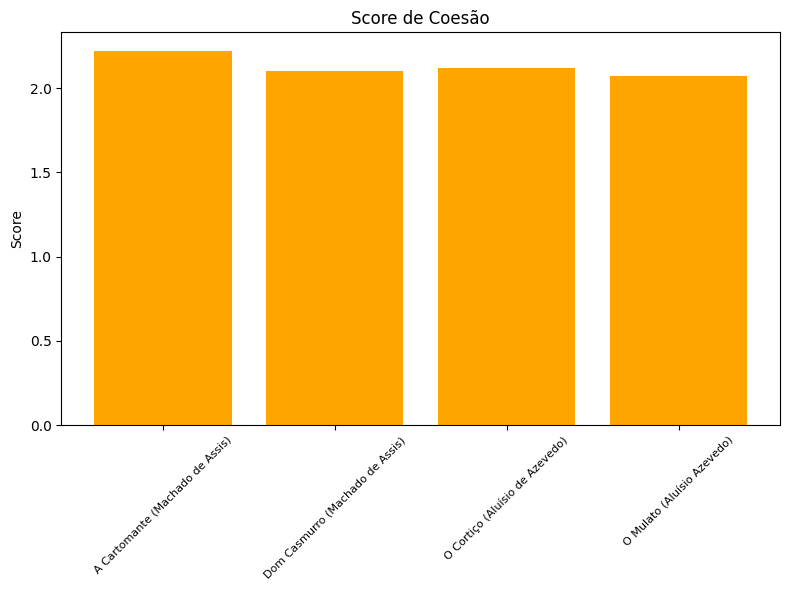

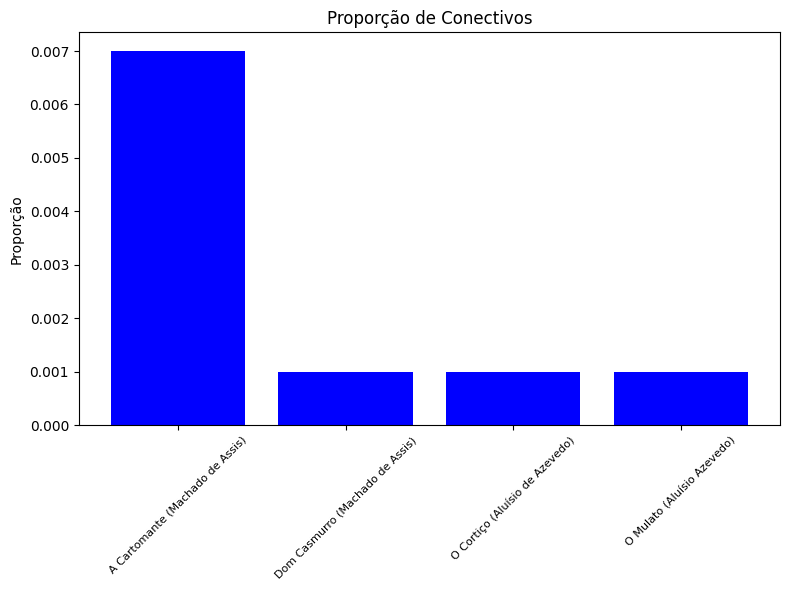

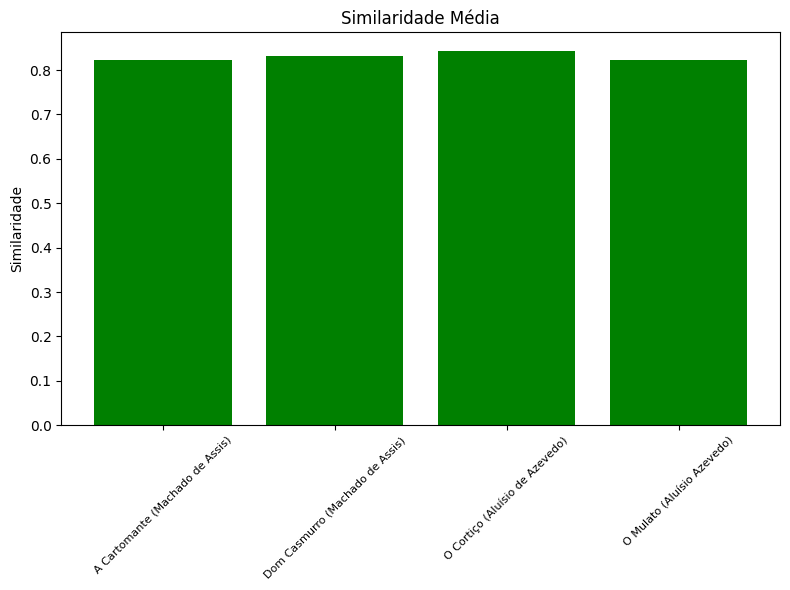

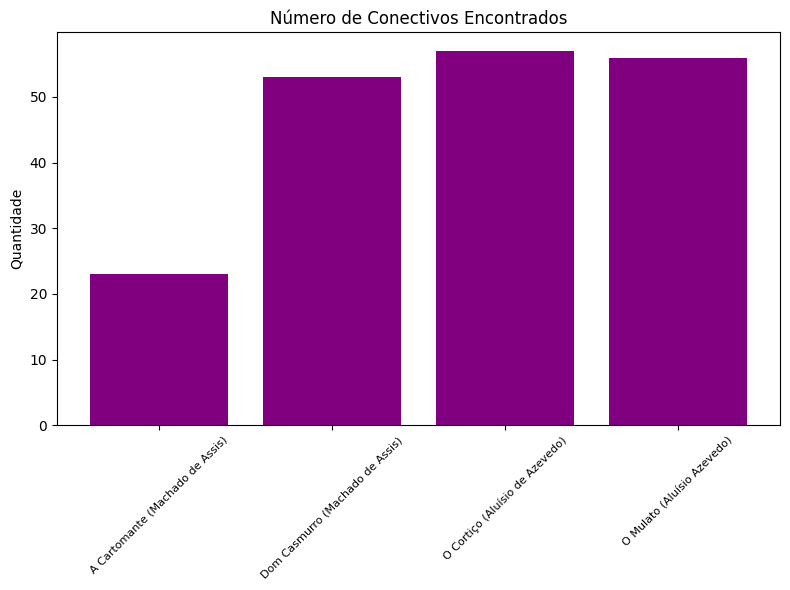

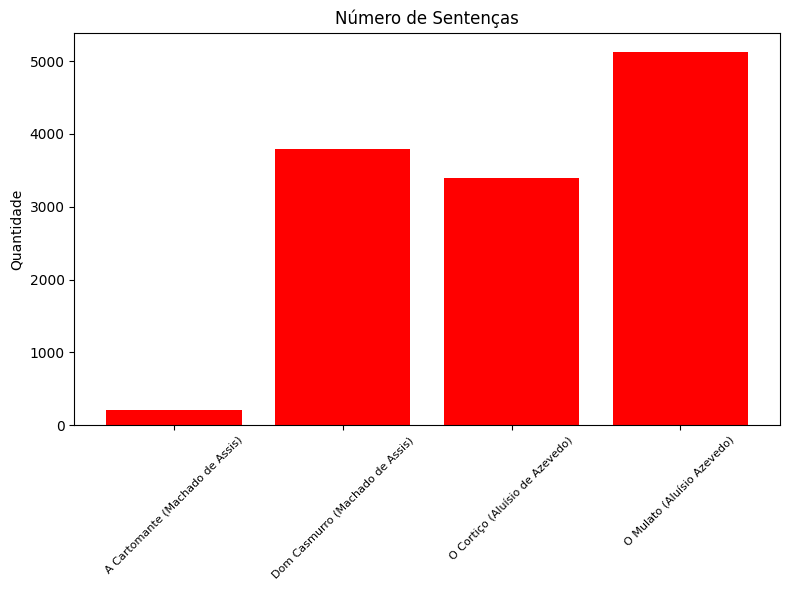

In [16]:
import matplotlib.pyplot as plt

# Dados fornecidos
arquivos = [
    "A Cartomante (Machado de Assis)",
    "Dom Casmurro (Machado de Assis)",
    "O Cortiço (Aluísio de Azevedo)",
    "O Mulato (Aluísio Azevedo)"
]
coesao_scores = [2.22, 2.1, 2.12, 2.07]
proporcoes_conectivos = [0.007, 0.001, 0.001, 0.001]
similaridades_medias = [0.823, 0.831, 0.843, 0.823]
num_conectivos = [23, 53, 57, 56]
num_sentencas = [206, 3789, 3400, 5132]

# Gráfico 1: Score de Coesão
plt.figure(figsize=(8, 6))
plt.bar(arquivos, coesao_scores, color='orange')
plt.title('Score de Coesão')
plt.ylabel('Score')
plt.xticks(rotation=45, fontsize=8)
plt.tight_layout()
plt.show()
plt.close()

# Gráfico 2: Proporção de Conectivos
plt.figure(figsize=(8, 6))
plt.bar(arquivos, proporcoes_conectivos, color='blue')
plt.title('Proporção de Conectivos')
plt.ylabel('Proporção')
plt.xticks(rotation=45, fontsize=8)
plt.tight_layout()
plt.show()
plt.close()

# Gráfico 3: Similaridade Média
plt.figure(figsize=(8, 6))
plt.bar(arquivos, similaridades_medias, color='green')
plt.title('Similaridade Média')
plt.ylabel('Similaridade')
plt.xticks(rotation=45, fontsize=8)
plt.tight_layout()
plt.show()
plt.close()

# Gráfico 4: Número de Conectivos Encontrados
plt.figure(figsize=(8, 6))
plt.bar(arquivos, num_conectivos, color='purple')
plt.title('Número de Conectivos Encontrados')
plt.ylabel('Quantidade')
plt.xticks(rotation=45, fontsize=8)
plt.tight_layout()
plt.show()
plt.close()

# Gráfico 5: Número de Sentenças
plt.figure(figsize=(8, 6))
plt.bar(arquivos, num_sentencas, color='red')
plt.title('Número de Sentenças')
plt.ylabel('Quantidade')
plt.xticks(rotation=45, fontsize=8)
plt.tight_layout()
plt.show()
plt.close()
